In [8]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 1

from numpy.random import seed
seed(rand_seed)
from tensorflow import set_random_seed
set_random_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

In [9]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10
    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features


In [10]:
path='ADD_PATH_To_Data'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

In [11]:
Features_imu,Labels,Features_sound = get_train_data()
print(Features_imu.shape, Labels.shape, Features_sound.shape)
print('Train Classes distribution: ',np.sum(Labels, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))



(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# Audio Model

In [12]:
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                       decay=0.0, amsgrad=False)

num_classes = 7


def build_scrath_sound_model_layers_diff():
    
    print('building the model ... ')
    
    model = Sequential()
    model.add(Dense(256, input_shape=(193,), activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', name = 'OUTPUT'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])
    return model

In [13]:
sound_model = build_scrath_sound_model_layers_diff()

building the model ... 


In [14]:
sound_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               49664     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
OUTPUT (Dense)               (None, 7)                 455       
Total params: 157,063
Trainable params: 157,063
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_path = '/home/nesl/Sandeep/Trained_models/Audio_Example'


from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_acc' ,save_best_only=True, save_weights_only=False)

In [16]:
import time
start_time = time.time()

epochs = 500
batch_size=128

learning_hist=sound_model.fit(Features_sound, Labels,
                    verbose=1,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer],
                    validation_data=(Features_sound2,Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

Train on 5000 samples, validate on 1000 samples
Epoch 1/500
5000/5000 [==============================] - 1s 247us/step - loss: 5.5469 - acc: 0.2430 - val_loss: 1.3679 - val_acc: 0.4460

Epoch 00001: val_acc improved from -inf to 0.44600, saving model to /home/nesl/Sandeep/Trained_models/Audio_Example
Epoch 2/500
5000/5000 [==============================] - 0s 40us/step - loss: 1.2563 - acc: 0.4698 - val_loss: 0.9794 - val_acc: 0.5740

Epoch 00002: val_acc improved from 0.44600 to 0.57400, saving model to /home/nesl/Sandeep/Trained_models/Audio_Example
Epoch 3/500
5000/5000 [==============================] - 0s 44us/step - loss: 0.9638 - acc: 0.6010 - val_loss: 0.7552 - val_acc: 0.7060

Epoch 00003: val_acc improved from 0.57400 to 0.70600, saving model to /home/nesl/Sandeep/Trained_models/Audio_Example
Epoch 4/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.8188 - acc: 0.6486 - val_loss: 0.6836 - val_acc: 0.7290

Epoch 00004: val_acc improved from 0.70600 to 0.7

5000/5000 [==============================] - 0s 48us/step - loss: 0.2811 - acc: 0.8702 - val_loss: 0.2656 - val_acc: 0.8850

Epoch 00040: val_acc did not improve from 0.89000
Epoch 41/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.3441 - acc: 0.8358 - val_loss: 0.3527 - val_acc: 0.8480

Epoch 00041: val_acc did not improve from 0.89000
Epoch 42/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.3570 - acc: 0.8450 - val_loss: 0.2871 - val_acc: 0.8790

Epoch 00042: val_acc did not improve from 0.89000
Epoch 43/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.3164 - acc: 0.8568 - val_loss: 0.2498 - val_acc: 0.8940

Epoch 00043: val_acc improved from 0.89000 to 0.89400, saving model to /home/nesl/Sandeep/Trained_models/Audio_Example
Epoch 44/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.2716 - acc: 0.8746 - val_loss: 0.2251 - val_acc: 0.9150

Epoch 00044: val_acc improved from 0.89400 to 0.91500,

5000/5000 [==============================] - 0s 48us/step - loss: 0.1125 - acc: 0.9568 - val_loss: 0.1066 - val_acc: 0.9660

Epoch 00079: val_acc did not improve from 0.96800
Epoch 80/500
5000/5000 [==============================] - 0s 46us/step - loss: 0.1010 - acc: 0.9608 - val_loss: 0.1423 - val_acc: 0.9560

Epoch 00080: val_acc did not improve from 0.96800
Epoch 81/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.1114 - acc: 0.9584 - val_loss: 0.0977 - val_acc: 0.9670

Epoch 00081: val_acc did not improve from 0.96800
Epoch 82/500
5000/5000 [==============================] - 0s 44us/step - loss: 0.1032 - acc: 0.9592 - val_loss: 0.1106 - val_acc: 0.9570

Epoch 00082: val_acc did not improve from 0.96800
Epoch 83/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.1106 - acc: 0.9572 - val_loss: 0.1304 - val_acc: 0.9580

Epoch 00083: val_acc did not improve from 0.96800
Epoch 84/500
5000/5000 [==============================] - 0s 48us/step - 

5000/5000 [==============================] - 0s 41us/step - loss: 0.0536 - acc: 0.9810 - val_loss: 0.1038 - val_acc: 0.9700

Epoch 00121: val_acc did not improve from 0.98500
Epoch 122/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0492 - acc: 0.9846 - val_loss: 0.0889 - val_acc: 0.9730

Epoch 00122: val_acc did not improve from 0.98500
Epoch 123/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0445 - acc: 0.9832 - val_loss: 0.0526 - val_acc: 0.9860

Epoch 00123: val_acc improved from 0.98500 to 0.98600, saving model to /home/nesl/Sandeep/Trained_models/Audio_Example
Epoch 124/500
5000/5000 [==============================] - 0s 50us/step - loss: 0.0372 - acc: 0.9868 - val_loss: 0.0519 - val_acc: 0.9850

Epoch 00124: val_acc did not improve from 0.98600
Epoch 125/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0369 - acc: 0.9886 - val_loss: 0.0798 - val_acc: 0.9740

Epoch 00125: val_acc did not improve from 0.98600



Epoch 00163: val_acc did not improve from 0.98800
Epoch 164/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0268 - acc: 0.9888 - val_loss: 0.0665 - val_acc: 0.9820

Epoch 00164: val_acc did not improve from 0.98800
Epoch 165/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0304 - acc: 0.9886 - val_loss: 0.0510 - val_acc: 0.9840

Epoch 00165: val_acc did not improve from 0.98800
Epoch 166/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0416 - acc: 0.9842 - val_loss: 0.0533 - val_acc: 0.9850

Epoch 00166: val_acc did not improve from 0.98800
Epoch 167/500
5000/5000 [==============================] - 0s 45us/step - loss: 0.0317 - acc: 0.9896 - val_loss: 0.0663 - val_acc: 0.9820

Epoch 00167: val_acc did not improve from 0.98800
Epoch 168/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0343 - acc: 0.9890 - val_loss: 0.1025 - val_acc: 0.9680

Epoch 00168: val_acc did not improve from 0.98800
Epoc


Epoch 00206: val_acc did not improve from 0.99000
Epoch 207/500
5000/5000 [==============================] - 0s 45us/step - loss: 0.0133 - acc: 0.9952 - val_loss: 0.0414 - val_acc: 0.9870

Epoch 00207: val_acc did not improve from 0.99000
Epoch 208/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0239 - acc: 0.9906 - val_loss: 0.0612 - val_acc: 0.9820

Epoch 00208: val_acc did not improve from 0.99000
Epoch 209/500
5000/5000 [==============================] - 0s 50us/step - loss: 0.0170 - acc: 0.9942 - val_loss: 0.0716 - val_acc: 0.9800

Epoch 00209: val_acc did not improve from 0.99000
Epoch 210/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0189 - acc: 0.9930 - val_loss: 0.0647 - val_acc: 0.9820

Epoch 00210: val_acc did not improve from 0.99000
Epoch 211/500
5000/5000 [==============================] - 0s 50us/step - loss: 0.0174 - acc: 0.9944 - val_loss: 0.0676 - val_acc: 0.9820

Epoch 00211: val_acc did not improve from 0.99000
Epoc


Epoch 00249: val_acc did not improve from 0.99100
Epoch 250/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0685 - acc: 0.9756 - val_loss: 0.0719 - val_acc: 0.9740

Epoch 00250: val_acc did not improve from 0.99100
Epoch 251/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0254 - acc: 0.9902 - val_loss: 0.0446 - val_acc: 0.9860

Epoch 00251: val_acc did not improve from 0.99100
Epoch 252/500
5000/5000 [==============================] - 0s 46us/step - loss: 0.0297 - acc: 0.9904 - val_loss: 0.0449 - val_acc: 0.9870

Epoch 00252: val_acc did not improve from 0.99100
Epoch 253/500
5000/5000 [==============================] - 0s 50us/step - loss: 0.0258 - acc: 0.9918 - val_loss: 0.0923 - val_acc: 0.9760

Epoch 00253: val_acc did not improve from 0.99100
Epoch 254/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0226 - acc: 0.9930 - val_loss: 0.0721 - val_acc: 0.9810

Epoch 00254: val_acc did not improve from 0.99100
Epoc

5000/5000 [==============================] - 0s 47us/step - loss: 0.0290 - acc: 0.9906 - val_loss: 0.1537 - val_acc: 0.9650

Epoch 00293: val_acc did not improve from 0.99100
Epoch 294/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0312 - acc: 0.9884 - val_loss: 0.0781 - val_acc: 0.9780

Epoch 00294: val_acc did not improve from 0.99100
Epoch 295/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0282 - acc: 0.9914 - val_loss: 0.0826 - val_acc: 0.9790

Epoch 00295: val_acc did not improve from 0.99100
Epoch 296/500
5000/5000 [==============================] - 0s 46us/step - loss: 0.0131 - acc: 0.9958 - val_loss: 0.0399 - val_acc: 0.9880

Epoch 00296: val_acc did not improve from 0.99100
Epoch 297/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0046 - acc: 0.9988 - val_loss: 0.0400 - val_acc: 0.9880

Epoch 00297: val_acc did not improve from 0.99100
Epoch 298/500
5000/5000 [==============================] - 0s 49us/st


Epoch 00335: val_acc did not improve from 0.99200
Epoch 336/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0516 - val_acc: 0.9900

Epoch 00336: val_acc did not improve from 0.99200
Epoch 337/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0096 - acc: 0.9964 - val_loss: 0.0773 - val_acc: 0.9860

Epoch 00337: val_acc did not improve from 0.99200
Epoch 338/500
5000/5000 [==============================] - 0s 46us/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0403 - val_acc: 0.9900

Epoch 00338: val_acc did not improve from 0.99200
Epoch 339/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0055 - acc: 0.9980 - val_loss: 0.0413 - val_acc: 0.9910

Epoch 00339: val_acc did not improve from 0.99200
Epoch 340/500
5000/5000 [==============================] - 0s 45us/step - loss: 0.0166 - acc: 0.9934 - val_loss: 0.0796 - val_acc: 0.9750

Epoch 00340: val_acc did not improve from 0.99200
Epoc

5000/5000 [==============================] - 0s 46us/step - loss: 0.1370 - acc: 0.9604 - val_loss: 0.1056 - val_acc: 0.9630

Epoch 00379: val_acc did not improve from 0.99200
Epoch 380/500
5000/5000 [==============================] - 0s 46us/step - loss: 0.0269 - acc: 0.9906 - val_loss: 0.0604 - val_acc: 0.9800

Epoch 00380: val_acc did not improve from 0.99200
Epoch 381/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0149 - acc: 0.9950 - val_loss: 0.0601 - val_acc: 0.9870

Epoch 00381: val_acc did not improve from 0.99200
Epoch 382/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0122 - acc: 0.9966 - val_loss: 0.0904 - val_acc: 0.9790

Epoch 00382: val_acc did not improve from 0.99200
Epoch 383/500
5000/5000 [==============================] - 0s 45us/step - loss: 0.0095 - acc: 0.9972 - val_loss: 0.0748 - val_acc: 0.9840

Epoch 00383: val_acc did not improve from 0.99200
Epoch 384/500
5000/5000 [==============================] - 0s 45us/st

5000/5000 [==============================] - 0s 45us/step - loss: 0.0084 - acc: 0.9976 - val_loss: 0.0574 - val_acc: 0.9850

Epoch 00422: val_acc did not improve from 0.99200
Epoch 423/500
5000/5000 [==============================] - 0s 50us/step - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0636 - val_acc: 0.9850

Epoch 00423: val_acc did not improve from 0.99200
Epoch 424/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0067 - acc: 0.9970 - val_loss: 0.1057 - val_acc: 0.9800

Epoch 00424: val_acc did not improve from 0.99200
Epoch 425/500
5000/5000 [==============================] - 0s 45us/step - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0554 - val_acc: 0.9880

Epoch 00425: val_acc did not improve from 0.99200
Epoch 426/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0062 - acc: 0.9978 - val_loss: 0.0788 - val_acc: 0.9860

Epoch 00426: val_acc did not improve from 0.99200
Epoch 427/500
5000/5000 [==============================] - 0s 45us/st

5000/5000 [==============================] - 0s 45us/step - loss: 0.0331 - acc: 0.9912 - val_loss: 0.0924 - val_acc: 0.9750

Epoch 00465: val_acc did not improve from 0.99200
Epoch 466/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0598 - acc: 0.9798 - val_loss: 0.0536 - val_acc: 0.9820

Epoch 00466: val_acc did not improve from 0.99200
Epoch 467/500
5000/5000 [==============================] - 0s 49us/step - loss: 0.0282 - acc: 0.9904 - val_loss: 0.0942 - val_acc: 0.9660

Epoch 00467: val_acc did not improve from 0.99200
Epoch 468/500
5000/5000 [==============================] - 0s 47us/step - loss: 0.0239 - acc: 0.9926 - val_loss: 0.0458 - val_acc: 0.9860

Epoch 00468: val_acc did not improve from 0.99200
Epoch 469/500
5000/5000 [==============================] - 0s 48us/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.0397 - val_acc: 0.9890

Epoch 00469: val_acc did not improve from 0.99200
Epoch 470/500
5000/5000 [==============================] - 0s 45us/st

In [17]:
from keras.models import load_model

sound_model = load_model(model_path)

In [18]:
#Train Accuracy
sound_model.evaluate(Features_sound,Labels)

5000/5000 [==============================] - 0s 53us/step


[0.0006571918953224668, 0.9998]

In [19]:
#valid Accuracy
sound_model.evaluate(Features_sound2,Labels2)

1000/1000 [==============================] - 0s 41us/step


[0.03415137107289047, 0.995]

In [20]:
#Test Accuracy
sound_model.evaluate(Features_sound3,Labels3)

1377/1377 [==============================] - 0s 43us/step


[0.6039950821457543, 0.9099491648511256]

# Plotting

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


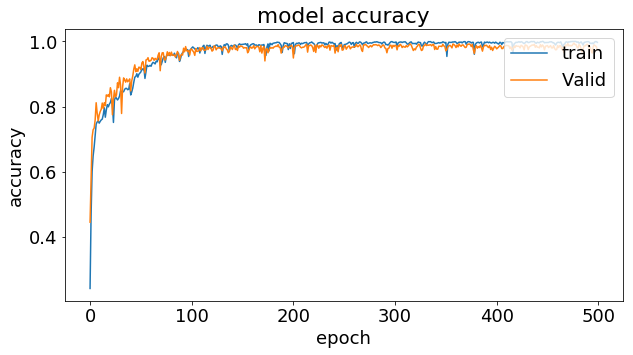

In [22]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['acc'])
plt.plot(learning_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()


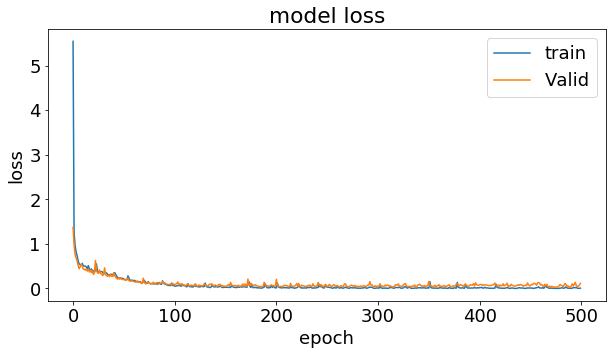

In [23]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()